In [2]:
pip install prophet

     |████████████████████████████████| 8.8 MB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 93 kB 3.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [834]:
%matplotlib inline
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import prophet

import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

warnings.filterwarnings('ignore')

In [1552]:
def MASE(Actual, Predicted):
    n = len(Actual)
    
    mae = mean_absolute_error(Actual, Predicted)

    # Calculate the denominator
    denominator = (1 / (n - 1)) * np.sum(np.abs(Actual[1:] - Actual[:-1]))

    # Avoid division by zero or small denominators
    if denominator > 1e-6:
        mase = mae / denominator
    else:
        mase = np.inf

    return mase

# data prep

In [9]:
east = pd.read_csv('data/east_daily.csv', index_col=0, parse_dates=[0])
midwest = pd.read_csv('data/midwest_daily.csv', index_col=0, parse_dates=[0]) 
south = pd.read_csv('data/south_daily.csv', index_col=0, parse_dates=[0]) 
west = pd.read_csv('data/west_daily.csv', index_col=0, parse_dates=[0]) 

In [12]:
east = east.sort_index()
midwest = midwest.sort_index()
south = south.sort_index()
west = west.sort_index()

In [313]:
train_size = int(len(east) * 0.9)

east_train, east_test = east[0:train_size], east[train_size:]
print(east_train.shape, east_test.shape)

midwest_train, midwest_test = midwest[0:train_size], midwest[train_size:]
print(midwest_train.shape, midwest_test.shape)

south_train, south_test = south[0:train_size], south[train_size:]
print(south_train.shape, south_test.shape)

west_train, west_test = west[0:train_size], west[train_size:]
print(west_train.shape, west_test.shape)

(1022, 1) (114, 1)
(1022, 1) (114, 1)
(1022, 1) (114, 1)
(1022, 1) (114, 1)


In [202]:
east_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(east_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

midwest_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

south_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(south_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

west_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(west_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

,TEST SET,TRAINING SET
date,,
2020-02-12,NaN,0.0
2020-02-13,NaN,0.0
2020-02-14,NaN,0.0
2020-02-15,NaN,0.0
2020-02-16,NaN,0.0
...,...,...
2023-03-19,0.0,NaN
2023-03-20,37.0,NaN
2023-03-21,33.0,NaN


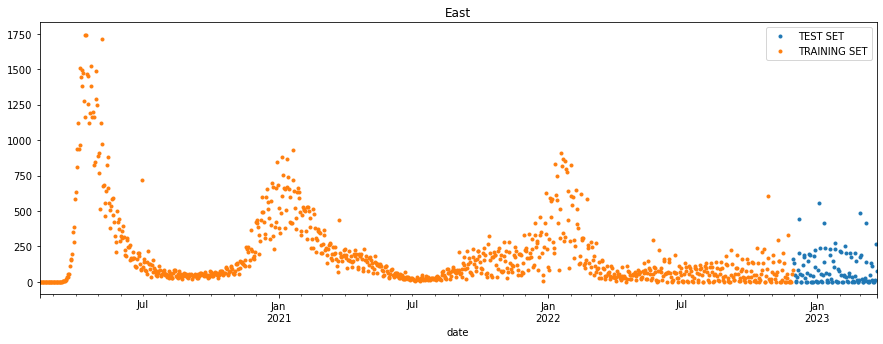

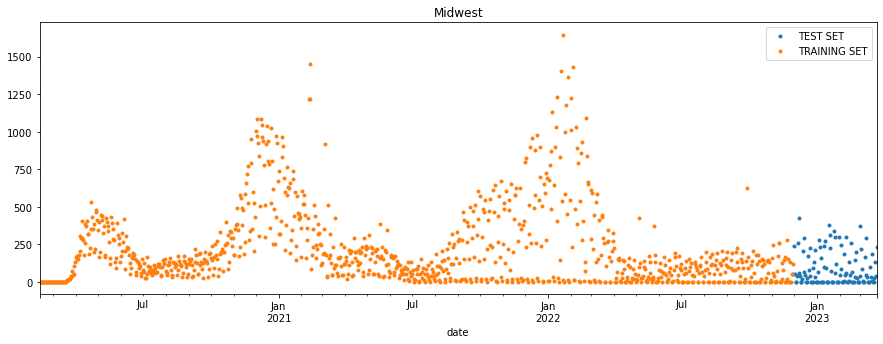

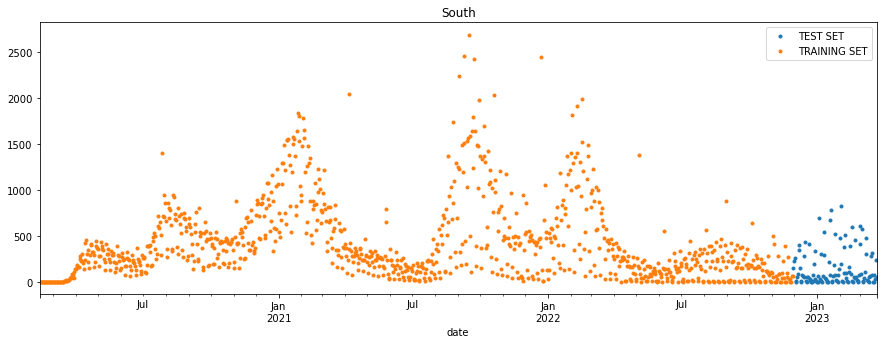

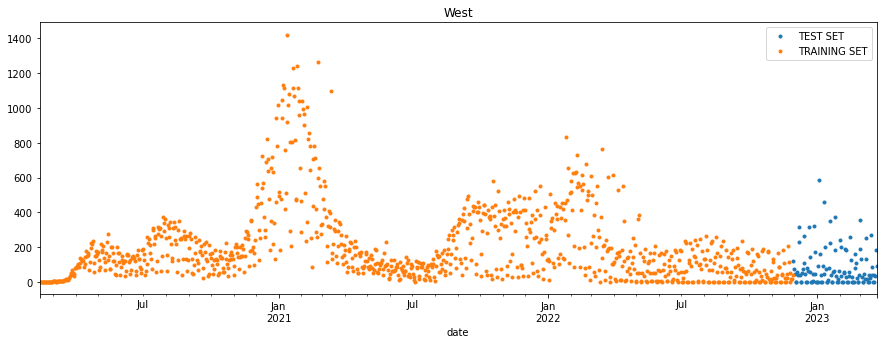

In [1610]:
_ = east_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(east_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='East', style='.')

_ = midwest_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Midwest', style='.')

_ = south_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(south_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='South', style='.')

_ = west_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(west_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='West', style='.')

# Univariate Prophet

### east

In [314]:
east_model = prophet.Prophet().fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))



03:05:56 - cmdstanpy - INFO - Chain [1] start processing
03:05:56 - cmdstanpy - INFO - Chain [1] done processing


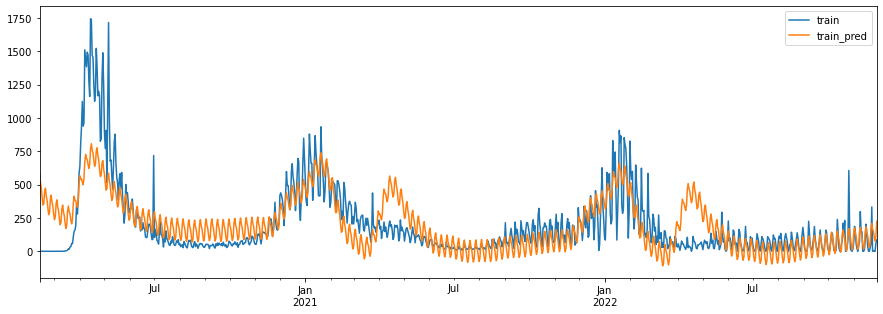

Training Set Metrics:
MAE: 126.31169182411163
MASE: 1.9373017072874457


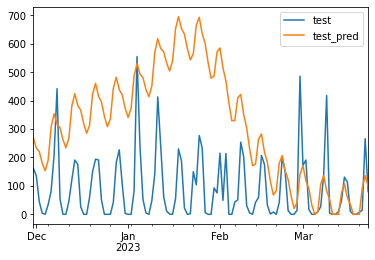

Testing Set Metrics:
MAE: 242.5279650823465
MASE: 2.7383753051863664


In [1273]:
train_pred=east_model.predict(east_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([east_train,train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(east_train.values, train_pred['yhat'].values)
mase_train = MASE(east_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=east_model.predict(east_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
east_test[east_test<0] = 0
pd.concat([east_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(east_test.values, test_pred['yhat'].values)
mase_test = MASE(east_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

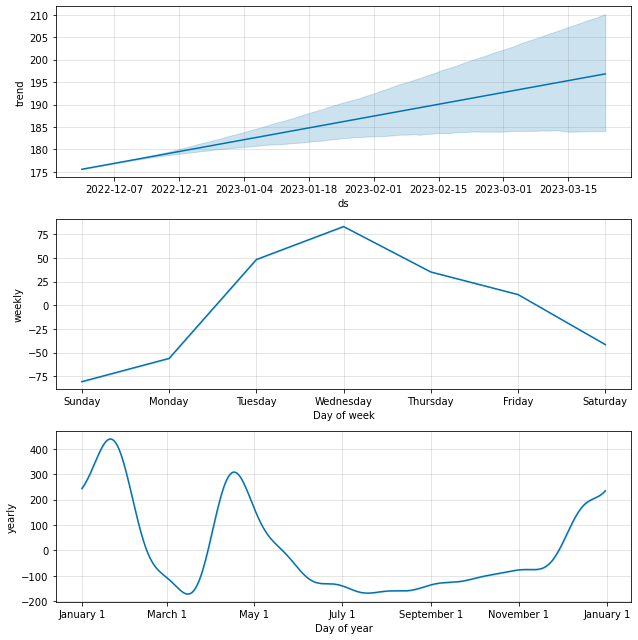

In [316]:
test_pred = test_pred.reset_index()

fig = east_model.plot_components(test_pred)
plt.show()

In [1602]:
east_model2 = prophet.Prophet(
    changepoint_prior_scale=0.02, # make trend less flexible (default is .05)
    yearly_seasonality = False # get rid of yearly seasonality
)

east_model2.add_seasonality(name='weekly', period=7, fourier_order = 3) # decrease weekly (default is 3)
east_model2.add_seasonality(name='monthly', period=30.5, fourier_order = 3) 

east_model2.fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

22:40:49 - cmdstanpy - INFO - Chain [1] start processing
22:40:49 - cmdstanpy - INFO - Chain [1] done processing


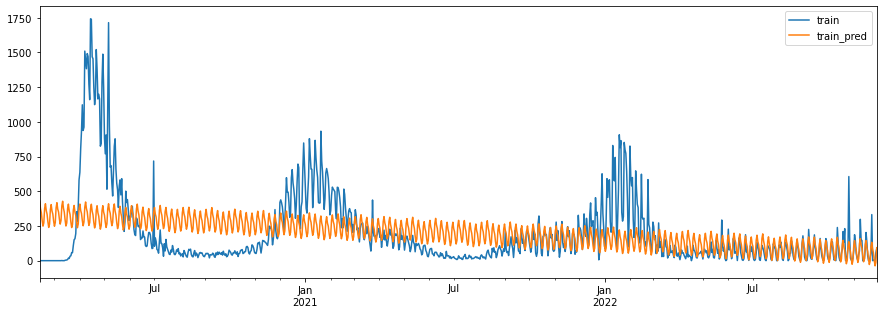

Training Set Metrics:
MAE: 159.9973754629822
MASE: 2.453954849069459


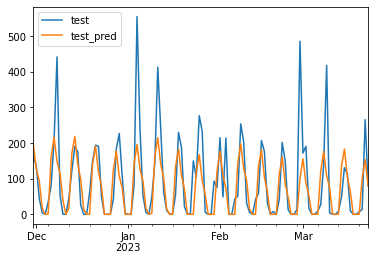

Testing Set Metrics:
MAE: 49.56568016320526
MASE: 0.559644470268005


In [1603]:
train_pred=east_model2.predict(east_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([east_train,train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(east_train.values, train_pred['yhat'].values)
mase_train = MASE(east_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=east_model2.predict(east_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
test_pred = test_pred * 1.5
east_test[east_test<0] = 0
pd.concat([east_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(east_test.values, test_pred['yhat'].values)
mase_test = MASE(east_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1597]:
east_model2 = prophet.Prophet(
    changepoint_prior_scale=0.02, # make trend less flexible (default is .05)
    yearly_seasonality = False # get rid of yearly seasonality
)

east_model2.add_seasonality(name='weekly', period=7, fourier_order=1) # decrease weekly (default is 3)
east_model2.add_seasonality(name='monthly', period=30.5, fourier_order=1) 

east_model2.fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

22:39:26 - cmdstanpy - INFO - Chain [1] start processing
22:39:27 - cmdstanpy - INFO - Chain [1] done processing


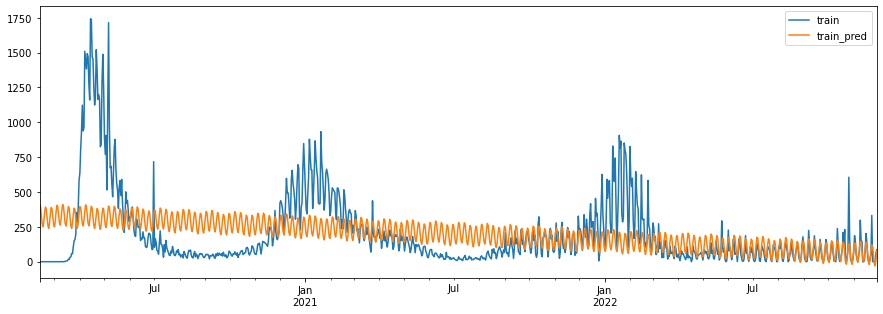

Training Set Metrics:
MAE: 159.75020932923275
MASE: 2.450163946058175


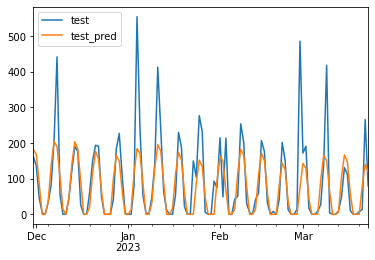

Testing Set Metrics:
MAE: 42.21994142283548
MASE: 0.47670397489812244


In [1598]:
train_pred=east_model2.predict(east_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([east_train,train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(east_train.values, train_pred['yhat'].values)
mase_train = MASE(east_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=east_model2.predict(east_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
test_pred = test_pred * 1.5
east_test[east_test<0] = 0
pd.concat([east_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(east_test.values, test_pred['yhat'].values)
mase_test = MASE(east_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

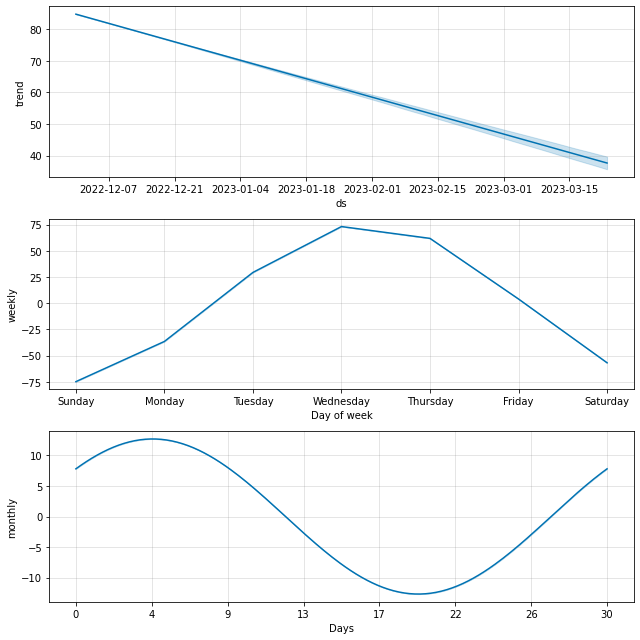

In [1599]:
test_pred = test_pred.reset_index()

fig = east_model2.plot_components(test_pred)
plt.show()

### midwest

In [120]:
midwest_model = prophet.Prophet().fit(midwest_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))


02:24:58 - cmdstanpy - INFO - Chain [1] start processing
02:24:58 - cmdstanpy - INFO - Chain [1] done processing


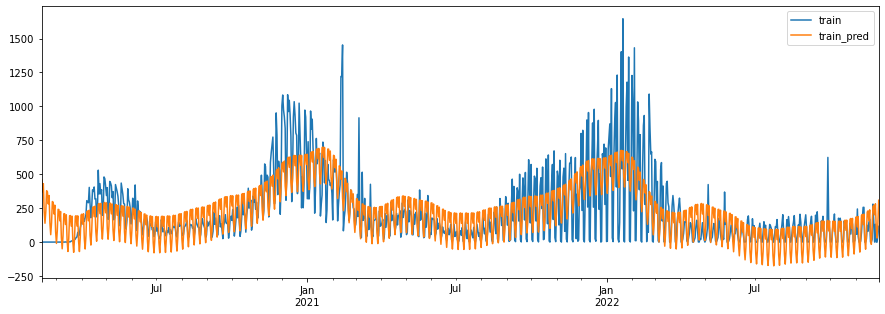

Training Set Metrics:
MAE: 122.3285532616534
MASE: 0.8972389253038613


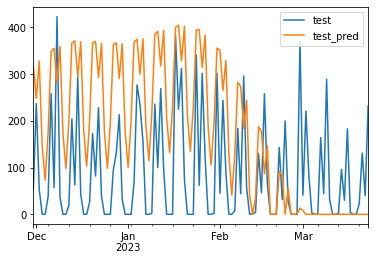

Testing Set Metrics:
MAE: 134.85975362548288
MASE: 1.1654291954481162


In [1275]:
train_pred=midwest_model.predict(midwest_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([midwest_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(midwest_train.values, train_pred['yhat'].values)
mase_train = MASE(midwest_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=midwest_model.predict(midwest_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
midwest_test[midwest_test<0] = 0
pd.concat([midwest_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(midwest_test.values, test_pred['yhat'].values)
mase_test = MASE(midwest_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

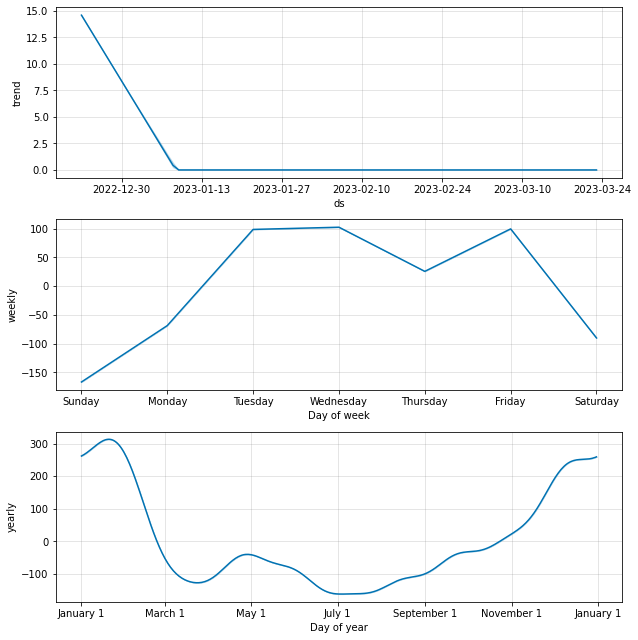

In [122]:
test_pred = test_pred.reset_index()

fig = midwest_model.plot_components(test_pred)
plt.show()

In [1604]:
midwest_model2 = prophet.Prophet(
    changepoint_prior_scale=0.02, # make trend less flexible (default is .05)
    yearly_seasonality = False # get rid of yearly seasonality
)

midwest_model2.add_seasonality(name='weekly', period=7, fourier_order=3) # add weekly (default is 3)
midwest_model2.add_seasonality(name='monthly', period=30.5, fourier_order=3) 

midwest_model2.fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

23:10:50 - cmdstanpy - INFO - Chain [1] start processing
23:10:51 - cmdstanpy - INFO - Chain [1] done processing


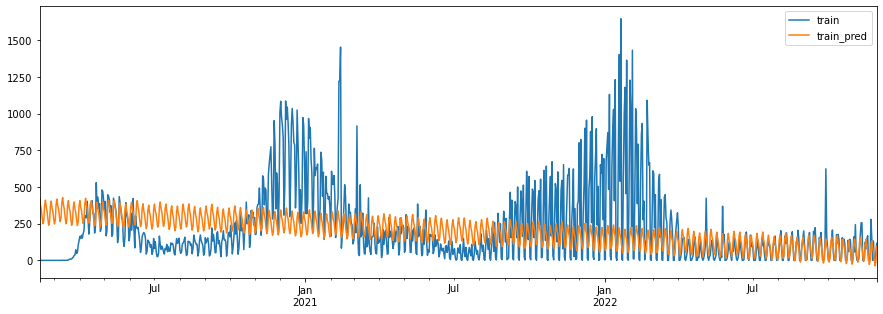

Training Set Metrics:
MAE: 163.8360314108012
MASE: 1.2016823613915606


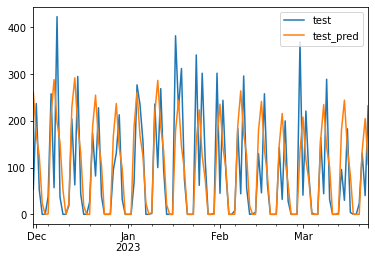

Testing Set Metrics:
MAE: 61.93445441897572
MASE: 0.5352243307849691


In [1605]:
train_pred=midwest_model2.predict(midwest_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([midwest_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(midwest_train.values, train_pred['yhat'].values)
mase_train = MASE(midwest_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=midwest_model2.predict(midwest_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
test_pred = test_pred * 2
midwest_test[midwest_test<0] = 0
pd.concat([midwest_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(midwest_test.values, test_pred['yhat'].values)
mase_test = MASE(midwest_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1583]:
midwest_model3 = prophet.Prophet(
    changepoint_prior_scale=0.02, # make trend less flexible (default is .05)
    yearly_seasonality = False # get rid of yearly seasonality
)

midwest_model3.add_seasonality(name='weekly', period=7, fourier_order=1) # add weekly (default is 3)
midwest_model3.add_seasonality(name='monthly', period=30.5, fourier_order=1) 

midwest_model3.fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing


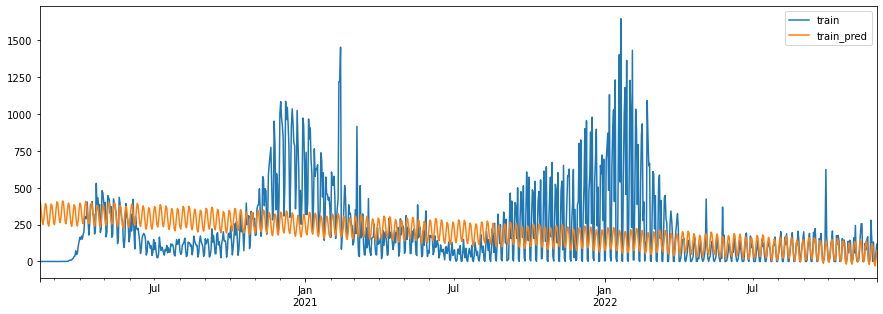

Training Set Metrics:
MAE: 163.94502955107197
MASE: 1.2024818262068393


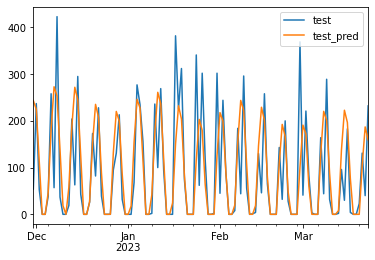

Testing Set Metrics:
MAE: 51.29153243816069
MASE: 0.4432504715136248


In [1590]:
train_pred=midwest_model3.predict(midwest_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([midwest_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(midwest_train.values, train_pred['yhat'].values)
mase_train = MASE(midwest_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=midwest_model3.predict(midwest_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
test_pred = test_pred * 2
midwest_test[midwest_test<0] = 0
pd.concat([midwest_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(midwest_test.values, test_pred['yhat'].values)
mase_test = MASE(midwest_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

### south

In [423]:
south_model = prophet.Prophet().fit(south_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))


03:28:18 - cmdstanpy - INFO - Chain [1] start processing
03:28:19 - cmdstanpy - INFO - Chain [1] done processing


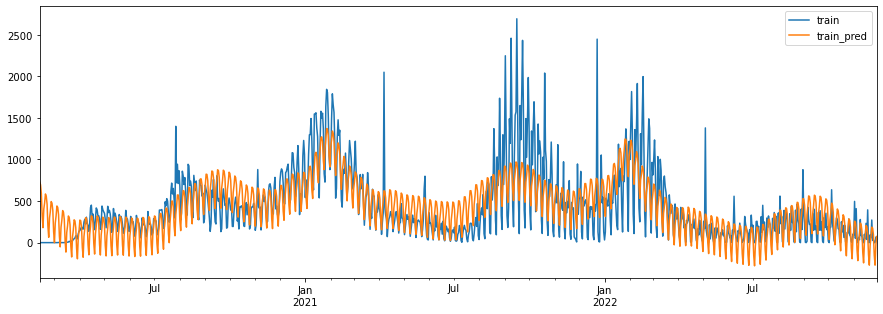

Training Set Metrics:
MAE: 208.75841189868515
MASE: 1.0198832393811936


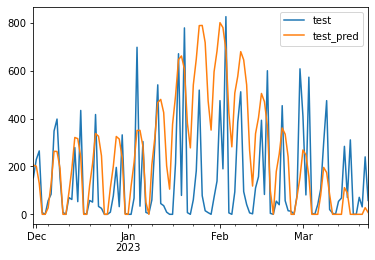

Testing Set Metrics:
MAE: 181.15935254019678
MASE: 0.9371884281940318


In [1277]:
train_pred=south_model.predict(south_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([south_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(south_train.values, train_pred['yhat'].values)
mase_train = MASE(south_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=south_model.predict(south_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
south_test[south_test<0] = 0
pd.concat([south_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(south_test.values, test_pred['yhat'].values)
mase_test = MASE(south_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

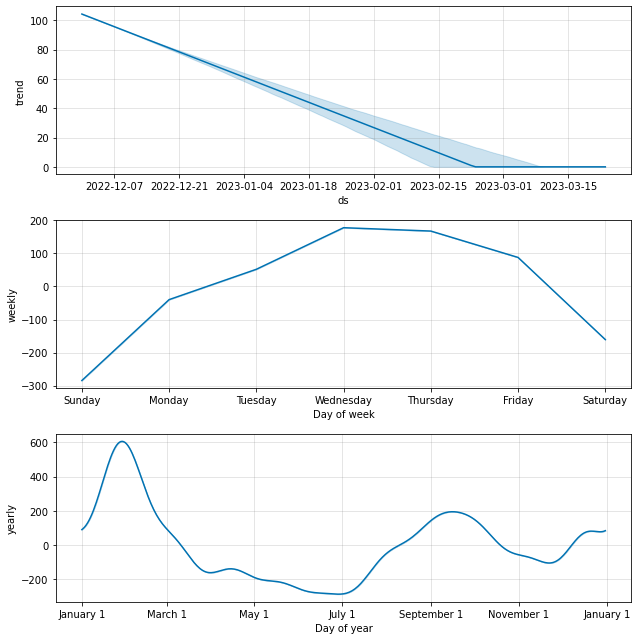

In [425]:
test_pred = test_pred.reset_index()

fig = south_model.plot_components(test_pred)
plt.show()

In [1606]:
south_model2 = prophet.Prophet(
    changepoint_prior_scale=0.02, # make trend less flexible (default is .05)
    yearly_seasonality = False # get rid of yearly seasonality
)

south_model2.add_seasonality(name='weekly', period=7, fourier_order=1) # add weekly (default is 3)
south_model2.add_seasonality(name='monthly', period=30.5, fourier_order=1) 

south_model2.fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

23:11:18 - cmdstanpy - INFO - Chain [1] start processing
23:11:18 - cmdstanpy - INFO - Chain [1] done processing


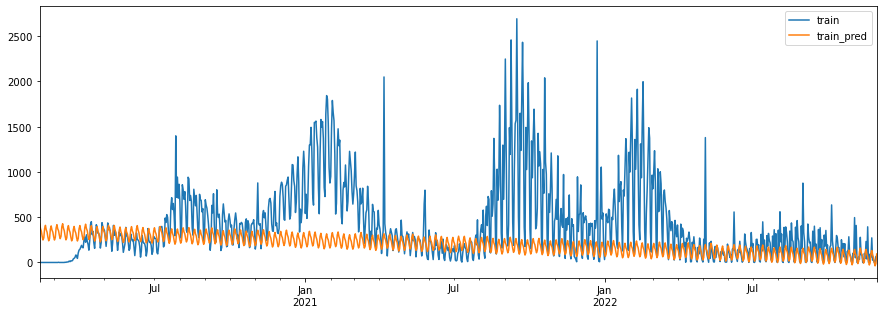

Training Set Metrics:
MAE: 289.8197529305478
MASE: 1.415906098188353


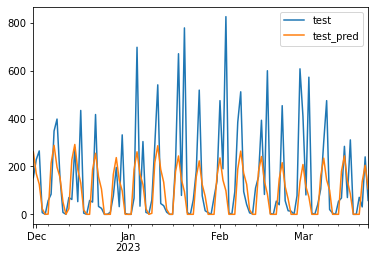

Testing Set Metrics:
MAE: 101.9713873543972
MASE: 0.5275267486630446


In [1607]:
train_pred=south_model2.predict(south_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([south_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(south_train.values, train_pred['yhat'].values)
mase_train = MASE(south_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=south_model2.predict(south_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
test_pred = test_pred * 2
south_test[south_test<0] = 0
pd.concat([south_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(south_test.values, test_pred['yhat'].values)
mase_test = MASE(south_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

### west

In [428]:
west_model = prophet.Prophet().fit(west_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))


03:29:12 - cmdstanpy - INFO - Chain [1] start processing
03:29:12 - cmdstanpy - INFO - Chain [1] done processing


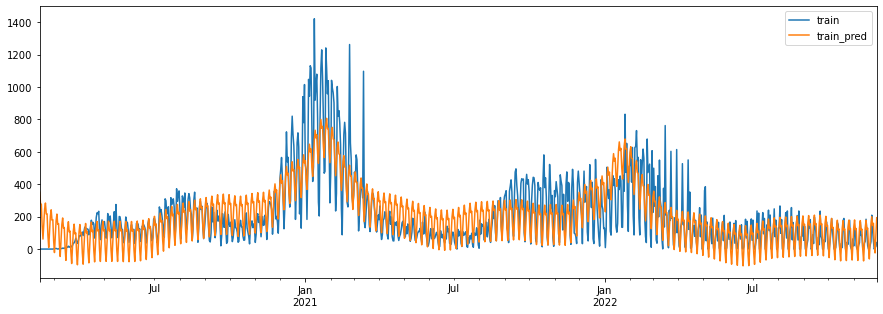

Training Set Metrics:
MAE: 95.048850991629
MASE: 0.9459855814872712


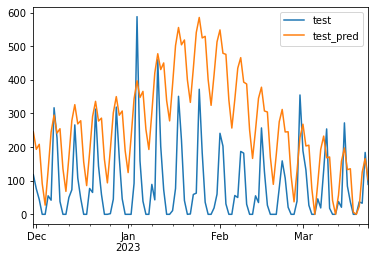

Testing Set Metrics:
MAE: 189.11045001820386
MASE: 2.1139065043087384


In [1279]:
train_pred=west_model.predict(west_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([west_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(west_train.values, train_pred['yhat'].values)
mase_train = MASE(west_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=west_model.predict(west_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
west_test[west_test<0] = 0
pd.concat([west_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(west_test.values, test_pred['yhat'].values)
mase_test = MASE(west_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

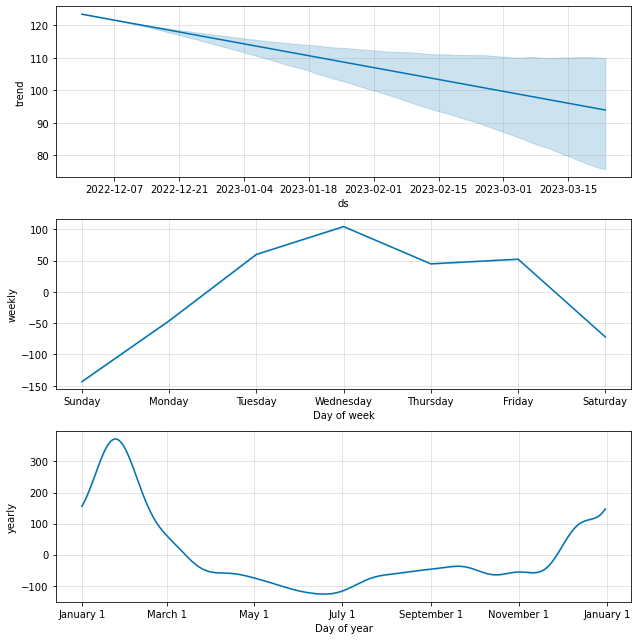

In [430]:
test_pred = test_pred.reset_index()

fig = west_model.plot_components(test_pred)
plt.show()

In [1608]:
west_model2 = prophet.Prophet(
    changepoint_prior_scale=0.02, # make trend less flexible (default is .05)
    yearly_seasonality = False # get rid of yearly seasonality
)

west_model2.add_seasonality(name='weekly', period=7, fourier_order=3) # add weekly (default is 3)
west_model2.add_seasonality(name='monthly', period=30.5, fourier_order=3) 

west_model2.fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

23:11:54 - cmdstanpy - INFO - Chain [1] start processing
23:11:54 - cmdstanpy - INFO - Chain [1] done processing


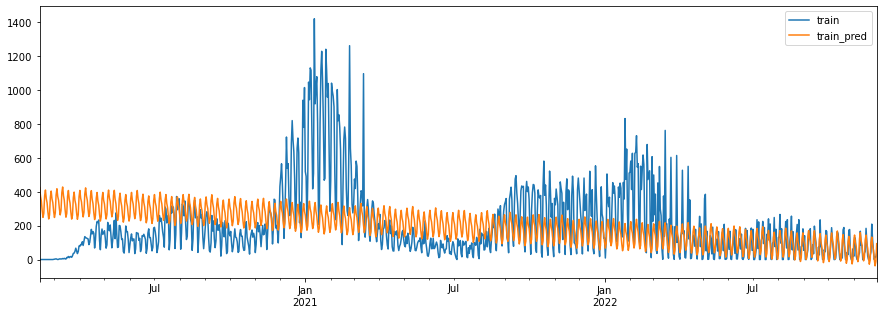

Training Set Metrics:
MAE: 147.13494926819317
MASE: 1.4643789913129006


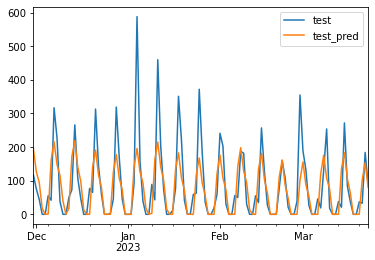

Testing Set Metrics:
MAE: 49.6651674297736
MASE: 0.5551650924487502


In [1609]:
train_pred=west_model2.predict(west_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([west_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(west_train.values, train_pred['yhat'].values)
mase_train = MASE(west_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=west_model2.predict(west_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
test_pred = test_pred * 1.5
west_test[west_test<0] = 0
pd.concat([west_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(west_test.values, test_pred['yhat'].values)
mase_test = MASE(west_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1595]:
west_model2 = prophet.Prophet(
    changepoint_prior_scale=0.02, # make trend less flexible (default is .05)
    yearly_seasonality = False # get rid of yearly seasonality
)

west_model2.add_seasonality(name='weekly', period=7, fourier_order=1) # add weekly (default is 3)
west_model2.add_seasonality(name='monthly', period=30.5, fourier_order=1) 

west_model2.fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

18:16:20 - cmdstanpy - INFO - Chain [1] start processing
18:16:20 - cmdstanpy - INFO - Chain [1] done processing


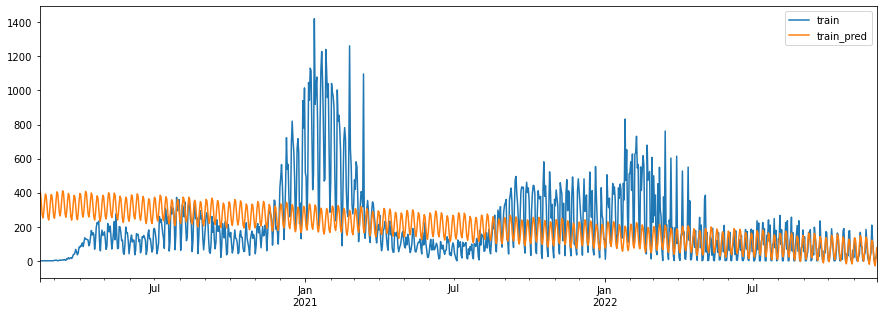

Training Set Metrics:
MAE: 146.67505506253556
MASE: 1.459801836691642


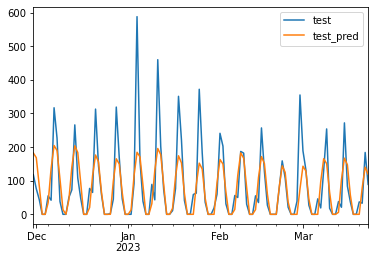

Testing Set Metrics:
MAE: 42.053857466922885
MASE: 0.4700846665112559


In [1596]:
train_pred=west_model2.predict(west_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([west_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(west_train.values, train_pred['yhat'].values)
mase_train = MASE(west_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=west_model2.predict(west_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
test_pred = test_pred * 1.5
west_test[west_test<0] = 0
pd.concat([west_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(west_test.values, test_pred['yhat'].values)
mase_test = MASE(west_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)